# Barotropic radius of deformation as a correlation length scale

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmitgcm import open_mdsdataset

#from barotropicradiusmatern import BarotropicRadiusMaternField
from matern import MaternField
from new_smooth_store import open_smoothdataset

In [2]:
grid_dir = '/scratch2/tsmith/generic-matern-covariance/sampling/llc90/grid'

In [3]:
ds = open_mdsdataset(grid_dir, geometry='llc', iters=None)

/home/tsmith/xmitgcm/xmitgcm/mds_store.py:924: UserWarning: Couldn't find available_diagnostics.log in /scratch2/tsmith/generic-matern-covariance/sampling/llc90/grid or /scratch2/tsmith/generic-matern-covariance/sampling/llc90/grid. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "


In [9]:
run_dir = '/scratch2/tsmith/generic-matern-covariance/sampling/llc90/matern-barotropic-radius/log10tol-04-3D-C/run.01dx.01xi/'
bds = open_smoothdataset(run_dir+'/smooth-output', run_dir, geometry='llc', read_filternorm=False)

In [10]:
run_dir = '/scratch2/tsmith/generic-matern-covariance/sampling/llc90/matern/log10tol-04-3D-C/run.10dx.01xi/'
mds = open_smoothdataset(run_dir+'/smooth-output', run_dir, geometry='llc', read_filternorm=False)

In [11]:
bds.data_vars

Data variables:
    smooth3Dfld001       (sample, k, face, j, i) float32 dask.array<chunksize=(1, 1, 3, 90, 90), meta=np.ndarray>
    smooth3DKux001       (k, face, j, i_g) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>
    smooth3DKvy001       (k, face, j_g, i) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>
    smooth3DKwz001       (k_l, face, j, i) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>
    smooth3DDelta001     (k, face, j, i) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>
    smooth3Dnorm001      (k, face, j, i) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>
    smooth3Dmean001      (k, face, j, i) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>
    smooth3DRandNorm001  (k, face, j, i) float32 dask.array<chunksize=(1, 3, 90, 90), meta=np.ndarray>

In [12]:
flist = ['smooth3DKux001', 'smooth3DKvy001', 'smooth3DKwz001', 'smooth3DDelta001', 'smooth3DRandNorm001']

smooth3DKux001 True
smooth3DKvy001 True
smooth3DKwz001 True
smooth3DDelta001 True
smooth3DRandNorm001 True


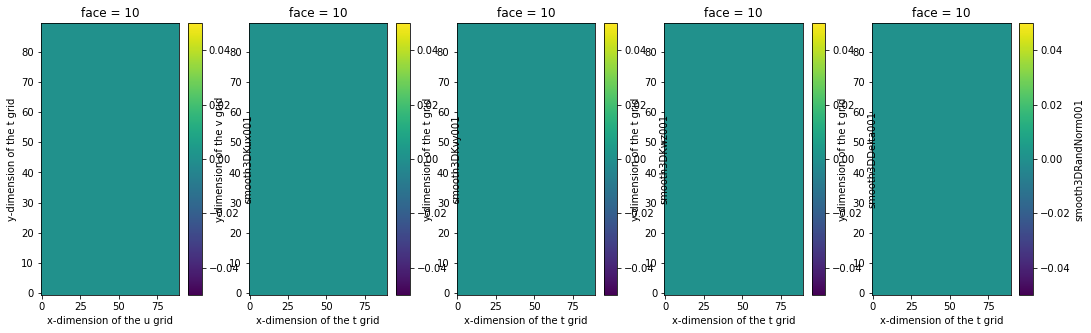

In [17]:
fig, axs = plt.subplots(1,5,figsize=(18,5))
for fname, ax in zip(flist,axs):
    plotme = bds[fname]
    
    plotme = np.isnan(plotme)
    #plotme = np.isinf(plotme)
    if 'k' in plotme.dims:
        plotme = plotme.any('k')
    elif 'k_l' in plotme.dims:
        plotme = plotme.any('k_l')
        
    print(fname, plotme.any().values)
    plotme = plotme.sel(face=10)
    plotme.plot(ax=ax)

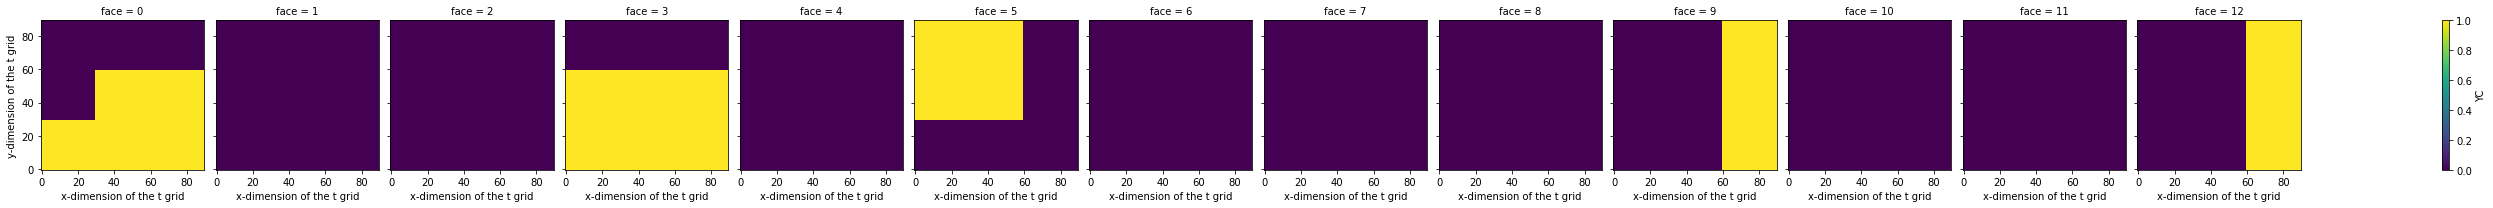

In [21]:
(bds.YC==0.).plot(col='face')

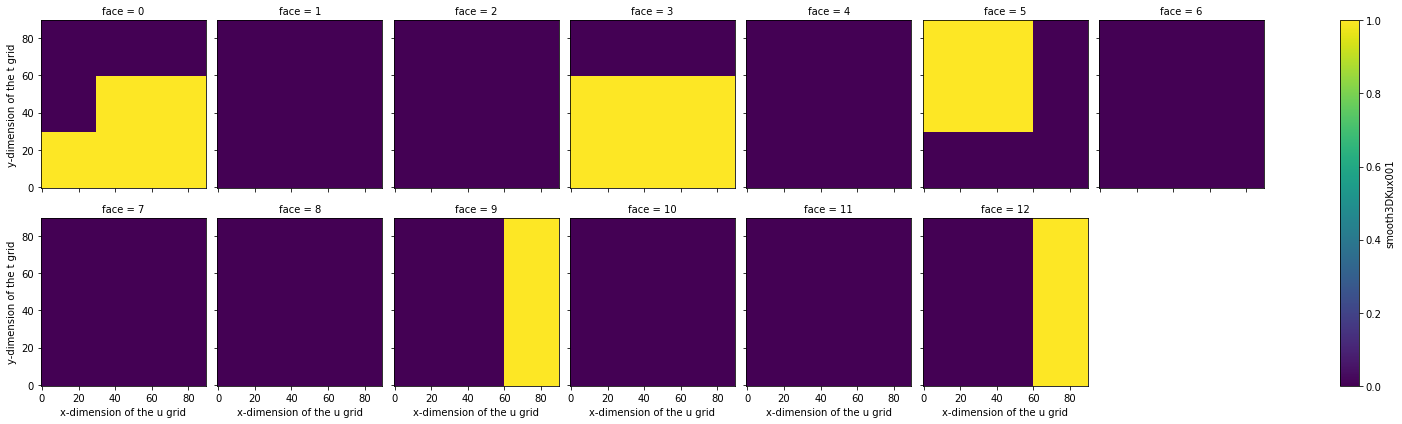

In [22]:
ff = np.isnan(bds['smooth3DKux001'])
ff = ff.any('k')
ff.plot(col='face', col_wrap=7)

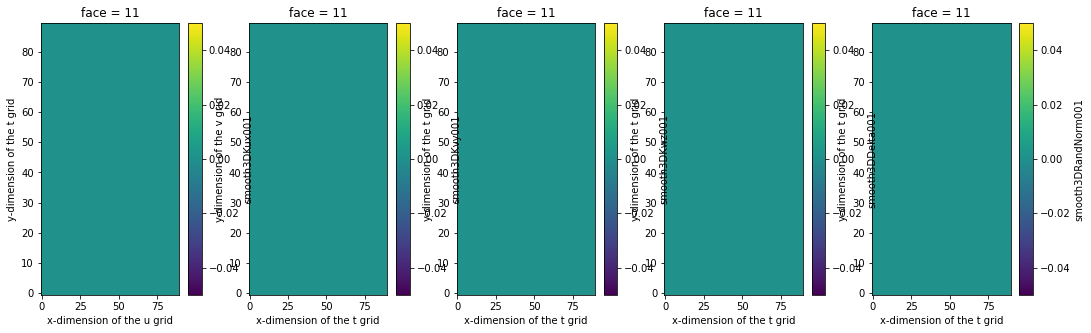

In [17]:
fig, axs = plt.subplots(1,5,figsize=(18,5))
for fname, ax in zip(flist,axs):
    plotme = mds[fname].sel(face=11)
    if 'k' in plotme.dims:
        plotme = plotme.any('k')
    elif 'k_l' in plotme.dims:
        plotme = plotme.any('k_l')
    #plotme = np.isnan(plotme)
    plotme = np.isinf(plotme)
    plotme.plot(ax=ax)

In [6]:
class BarotropicRadiusMaternField(MaternField):
    """Matern field with horizontal length scales defined by
    the Barotropic Rossby radius of deformation
    """

    def get_horizontal_length_scale(self, xds):
        """Get horizontal length scale from data array or dataset"""

        xds = xds.to_dataset(name='tmp') if isinstance(xds, xr.DataArray) else xds

        assert 'YC' in xds and 'Depth' in xds, "Must have YC and Depth in dataset"

        g       = 9.81 # m/s^2
        omega   = 7.2921e-5
        earthrad= 6_371_000
        radlat  = np.deg2rad(xds["YC"])
        f       = 2 * omega * np.sin(radlat)
        beta    = 2 * omega * np.cos(radlat) / earthrad
        
        Cg      = g*xds["Depth"]
        denom   = f**2 + 2*beta*Cg

        Lx = np.sqrt(Cg**2 / denom)
        Lx = Lx.astype(xds.YC.dtype)
        Ly = Lx.copy()

        Lx.name = 'Lx'
        Ly.name = 'Ly'
        return Lx, Ly

In [7]:
bmf = BarotropicRadiusMaternField(ds.maskC, n_range=1, horizontal_factor=1.)
bmf.write_binaries('test_dir', 1)

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float32


/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float32


/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float32


/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float32


/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (50, 90, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array dtype float32


In [14]:
bb = open_smoothdataset('test_dir', 'test_dir', geometry='llc', iters=None)

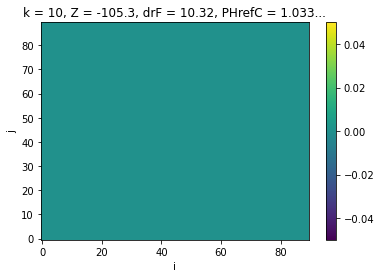

In [11]:
#np.isnan(bmf.K['ux']).sel(k=10,face=10).plot()
#np.isinf(bmf.detPhi).sel(k=10,face=10).plot()
np.isinf(bmf.rhs_factor).sel(k=10,face=10).plot()

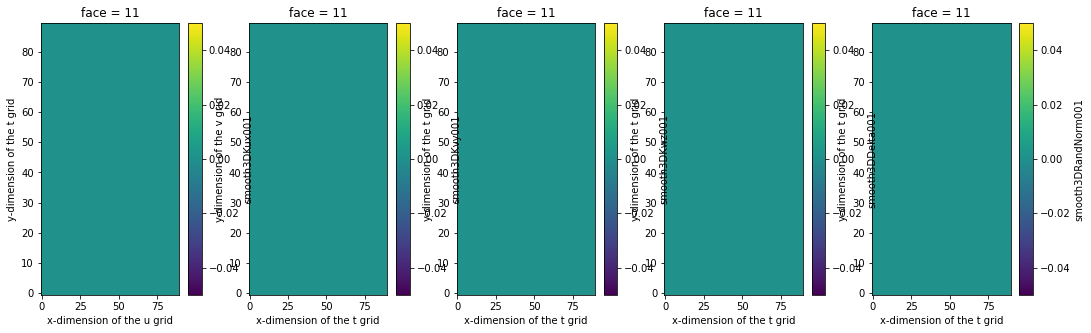

In [16]:
fig, axs = plt.subplots(1,5,figsize=(18,5))
for fname, ax in zip(flist,axs):
    
    plotme = bb[fname].sel(face=11)
    
    #plotme = np.isnan(plotme)
    plotme = np.isinf(plotme)
    
    if 'k' in plotme.dims:
        plotme = plotme.any('k')
        #plotme = plotme.sel({'k':10})
    elif 'k_l' in plotme.dims:
        plotme = plotme.any('k_l')
        #plotme = plotme.sel({'k_l':10})
    plotme.plot(ax=ax)

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


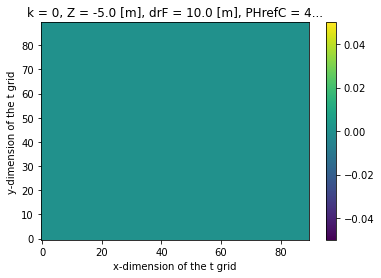

In [24]:
np.isnan(bmf.rhs_factor.isel(k=0,face=10)).plot()

In [20]:
mf = MaternField(ds.maskC, n_range=1, horizontal_factor=1)

In [21]:
phixb = bmf.K["ux"].isel(k=0)
phix  = mf.K["ux"].isel(k=0)

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


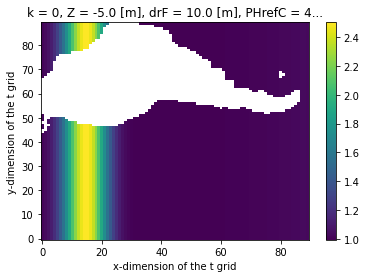

In [22]:
(phixb / phix).where(ds.maskC.isel(k=0)).sel(face=11).plot()

In [34]:
ds.YC.dtype

dtype('>f4')

In [33]:
bmf.Lx.sel(face=10).astype(ds.YC.dtype)

<xarray.DataArray 'Lx' (j: 90, i: 90)>
dask.array<astype, shape=(90, 90), dtype=>f4, chunksize=(90, 90), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    face     int64 10
    XC       (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    YC       (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    CS       (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    ...       ...
    rA       (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    Depth    (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    dxF      (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    dyF      (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    rLowC    (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>
    rSurfC   (j, i) >f4 dask.array<chunksize=(90, 90), meta=np.ndarray>

In [31]:
ds.YC.dtype

dtype('>f4')

In [23]:
phixb

<xarray.DataArray (face: 13, j: 90, i: 90)>
dask.array<getitem, shape=(13, 90, 90), dtype=float64, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates: (12/18)
    k        int64 0
    Z        >f4 -5.0
    drF      >f4 10.0
    PHrefC   >f4 49.05
    rhoRef   >f4 1.024e+03
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    ...       ...
    rA       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth    (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rLowC    (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfC   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>

In [74]:
#ratio = (bmf.delta / mf.delta).where(ds.maskC)
ratio = (bmf.detPhi / mf.detPhi).where(ds.maskC)

In [25]:
phixb

<xarray.DataArray (face: 13, j: 90, i: 90)>
dask.array<getitem, shape=(13, 90, 90), dtype=float64, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates: (12/18)
    k        int64 0
    Z        >f4 -5.0
    drF      >f4 10.0
    PHrefC   >f4 49.05
    rhoRef   >f4 1.024e+03
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    ...       ...
    rA       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth    (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rLowC    (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfC   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>

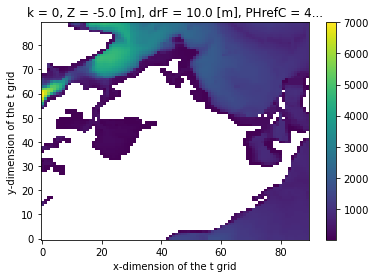

In [77]:
ratio.sel(face=10,k=0).plot()

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


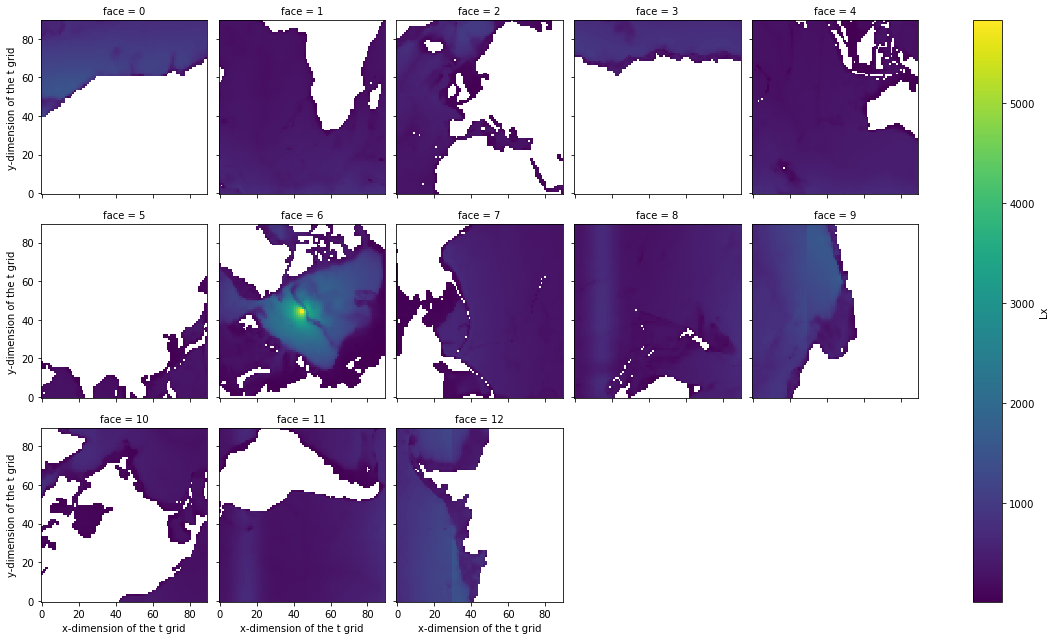

In [26]:
(bmf.Lx / mf.Lx).where(ds.maskC.isel(k=0)).plot(col='face', col_wrap=5)

In [27]:
ratio = (bmf.Lx / mf.Lx).where(ds.maskC.isel(k=0))

In [32]:
ratio.sel(face=8).max().values

array(778.16890084)